# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [14]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

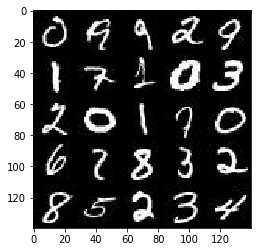

In [15]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

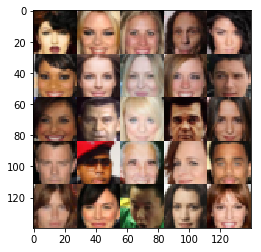

In [16]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [18]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    #the first none is the batch size
    input_images=tf.placeholder(tf.float32,shape=(None,image_width, image_height, image_channels),name="input_images")
    z_data=tf.placeholder(tf.float32,shape=(None,z_dim),name="z_data")
    learning_rate = tf.placeholder(tf.float32,name="learning_rate")

    return input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [19]:
#TIPP: Good value of alpha/ leak parameter has been chosen. However, still try lowering to 0.1 .

def leaky_relu(var,alpha=0.1): # like the idea of leaky relus and therefore want to use them here
    return tf.maximum(alpha * var, var)
    
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function - reusing a lot from the DCGAN.ipynb homework
    
    # TIPP: Use a smaller model for the discriminator relative to generator. 
    
    # TIPP: You used random_normal_intialiser. However, using weight initialization: 
    # Xavier initialization (A good blog link to help understand what it's) 
    # is recommended so as to break symmetry and thus, help converge faster as well as prevent local minima
    
    with tf.variable_scope('discriminator',reuse=reuse):
        # Input layer is 28x28x3 or 28x28x3
        x1 = tf.layers.conv2d(images, 32, 5, strides=2, padding='same',
                              kernel_initializer = tf.contrib.layers.xavier_initializer())#tf.random_normal_initializer(stddev=0.02))
        rl1 = leaky_relu(x1)
        # 14x14x32
        
        x2 = tf.layers.conv2d(rl1, 64, 5, strides=1, padding='same',
                              kernel_initializer = tf.contrib.layers.xavier_initializer())# tf.random_normal_initializer(stddev=0.02))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        rl2 = leaky_relu(bn2)
        # 14x14x64
        
        x3 = tf.layers.conv2d(rl2, 256, 5, strides=2, padding='same',
                              kernel_initializer = tf.contrib.layers.xavier_initializer())# tf.random_normal_initializer(stddev=0.02))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        rl3 = leaky_relu(bn3)
        
        # TIPP: Use Dropouts in discrimnator so as 
        # to make it less prone to the mistakes the 
        # generator can exploit instead of learning the 
        # data distribution as mentioned here. Possible 
        # tensorflow implementation can be achieved by simply 
        # passing the outputs from last layer into the tf.nn.dropout 
        # with a high keep_probability. USING tf.layers.dropout, thus I have to to 1-keep_prob
        # https://www.tensorflow.org/api_docs/python/tf/layers/dropout
        
        # 7x7x256
        # print ('shape', rl3.shape)

        do3 = tf.layers.dropout(rl3,rate=0.05)# 1-keep_prob of 0.95 = 0.05 cf. https://www.tensorflow.org/api_docs/python/tf/layers/dropout
        
        # Flatten it
        
        
        flat = tf.reshape(do3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [20]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function - reusing a lot from the DCGAN.ipynb homework
    
    # TIPP: Use a smaller model for the discriminator relative to generator. 
    # Simply increase the number of filters for each layer in the generator by at least a 
    # factor of 2. Also, a sharp decline in generator from 1st to 2nd layer, for instance 
    # from 512 to 64, has shown to produce good results.
    
    # TIPP: Use Dropouts(50%) in generator in both train and test phase so as to provide noise 
    # and apply on several layers of generator at both training and test time. 
    # This was first introduced in a image tanslation paper called pix2pix for 
    # which you can check out an awesome demo here.
    
    with tf.variable_scope('generator',reuse= not is_train):
        # First fully connected layer
        fc1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        
        
        
        x1 = tf.reshape(fc1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        rl1 = leaky_relu(bn1)
        do1 = tf.layers.dropout(rl1,rate=0.5)
        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(do1, filters=128, kernel_size=7, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        rl2 = leaky_relu(bn2)
        do2 = tf.layers.dropout(rl2,rate=0.5)
        # 14x14x128
        
        x3 = tf.layers.conv2d_transpose(do2, filters=64, kernel_size=5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        rl3 = leaky_relu(bn3)
        do3 = tf.layers.dropout(rl3,rate=0.5)
        # 14x14x64
        #print ('shape', rl3.shape)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(do3, out_channel_dim, kernel_size=5, strides=2, padding='same')
        # 28x28x3 or 28x28x1
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [21]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function - reusing a lot from the DCGAN.ipynb homework
    
    
    # the real pipeline 
    dis_model_real, dis_logits_real = discriminator(input_real, reuse=False)
    
    
    # the generated pipeline
    gen_model = generator(input_z, out_channel_dim, is_train=True)
    dis_model_fake, dis_logits_fake = discriminator(gen_model, reuse=True)
    
    
    #calculating the loss for the real images
    dis_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_real, labels=tf.ones_like(dis_model_real)*0.9))#smoothin of 0.1
    #calculating the loss for the fake images
    dis_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.zeros_like(dis_model_fake)))
    # calculating the loss of the descriminator
    dis_loss = dis_loss_real + dis_loss_fake
    


    # calculating how well the generator tricks the desriminator
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.ones_like(dis_model_fake)))
    
    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [22]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function - reusing a lot from the DCGAN.ipynb homework
    
    # Get variables for the different models
    t_vars = tf.trainable_variables()
    dis_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in t_vars if var.name.startswith('generator')]
    #print([var.name for var in t_vars])
    #print([var.name for var in dis_vars])
    #print([var.name for var in gen_vars])

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        dis_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_vars)
        gen_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)

    return dis_train_opt, gen_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [24]:
def train(epoch_count, batch_size, z_dim, learning_rate_, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # the last parameter data_image_mode can be always taken from data_shape[3] 3 gdw RGB 1 gdw L
    # TODO: Build Model - reusing a lot from the DCGAN.ipynb homework
    image_width = data_shape[1]
    image_height = data_shape[2] 
    image_channels = data_shape[3] # the last parameter data_image_mode can be always taken from data_shape[3] 3 gdw RGB 1 gdw L
    
    input_images, z_data, learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    dis_loss, gen_loss = model_loss(input_images, z_data, image_channels)
    dis_opt, gen_opt = model_opt(dis_loss, gen_loss, learning_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # Sample random noise for G
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # scale images to the size output of the tanh function -1.0 .. 1.0 from -0.5 .. 0.5 cf. helper.py
                images = batch_images * 2.0
                
                # Run optimizers
                _ = sess.run(dis_opt, feed_dict={input_images: images, z_data: batch_z, learning_rate: learning_rate_})
                _ = sess.run(gen_opt, feed_dict={input_images: images, z_data: batch_z, learning_rate: learning_rate_})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_dis = dis_loss.eval({input_images: images, z_data: batch_z, learning_rate: learning_rate_})
                    train_loss_gen = gen_loss.eval({input_images: images, z_data: batch_z, learning_rate: learning_rate_})
                    #show_generator_output(sess, 16, z_data, image_channels, data_image_mode)
                    print("Epoch {}/{} - steps: {}...".format(epoch_i+1, epochs,steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_dis),
                          "Generator Loss: {:.4f}".format(train_loss_gen))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 25, z_data, image_channels, data_image_mode)
        show_generator_output(sess, 25, z_data, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 - steps: 10... Discriminator Loss: 0.7126... Generator Loss: 1.3429
Epoch 1/2 - steps: 20... Discriminator Loss: 1.7239... Generator Loss: 0.3434
Epoch 1/2 - steps: 30... Discriminator Loss: 0.6723... Generator Loss: 4.5823
Epoch 1/2 - steps: 40... Discriminator Loss: 1.0976... Generator Loss: 0.7483
Epoch 1/2 - steps: 50... Discriminator Loss: 0.5864... Generator Loss: 5.3739
Epoch 1/2 - steps: 60... Discriminator Loss: 1.0515... Generator Loss: 1.1012
Epoch 1/2 - steps: 70... Discriminator Loss: 1.1156... Generator Loss: 1.1039
Epoch 1/2 - steps: 80... Discriminator Loss: 1.4043... Generator Loss: 0.6610
Epoch 1/2 - steps: 90... Discriminator Loss: 1.1502... Generator Loss: 2.4073
Epoch 1/2 - steps: 100... Discriminator Loss: 1.7008... Generator Loss: 0.3749


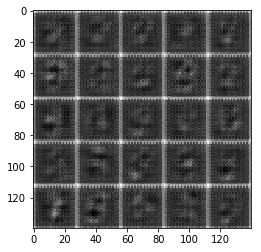

Epoch 1/2 - steps: 110... Discriminator Loss: 1.8895... Generator Loss: 3.1431
Epoch 1/2 - steps: 120... Discriminator Loss: 0.9386... Generator Loss: 1.0539
Epoch 1/2 - steps: 130... Discriminator Loss: 1.2876... Generator Loss: 0.6007
Epoch 1/2 - steps: 140... Discriminator Loss: 0.9713... Generator Loss: 1.1147
Epoch 1/2 - steps: 150... Discriminator Loss: 0.9775... Generator Loss: 0.9548
Epoch 1/2 - steps: 160... Discriminator Loss: 0.9939... Generator Loss: 1.1204
Epoch 1/2 - steps: 170... Discriminator Loss: 0.8804... Generator Loss: 1.6549
Epoch 1/2 - steps: 180... Discriminator Loss: 1.7247... Generator Loss: 0.3326
Epoch 1/2 - steps: 190... Discriminator Loss: 0.9297... Generator Loss: 1.9452
Epoch 1/2 - steps: 200... Discriminator Loss: 0.9023... Generator Loss: 1.0805


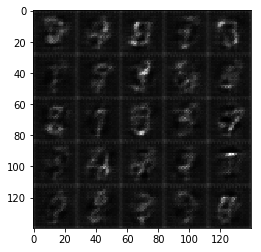

Epoch 1/2 - steps: 210... Discriminator Loss: 0.7786... Generator Loss: 1.8562
Epoch 1/2 - steps: 220... Discriminator Loss: 0.9544... Generator Loss: 2.2838
Epoch 1/2 - steps: 230... Discriminator Loss: 0.9237... Generator Loss: 1.4470
Epoch 1/2 - steps: 240... Discriminator Loss: 0.7824... Generator Loss: 1.4611
Epoch 1/2 - steps: 250... Discriminator Loss: 0.8464... Generator Loss: 1.1689
Epoch 1/2 - steps: 260... Discriminator Loss: 0.8365... Generator Loss: 1.2816
Epoch 1/2 - steps: 270... Discriminator Loss: 1.0716... Generator Loss: 0.7780
Epoch 1/2 - steps: 280... Discriminator Loss: 1.2409... Generator Loss: 0.6380
Epoch 1/2 - steps: 290... Discriminator Loss: 0.9908... Generator Loss: 1.8600
Epoch 1/2 - steps: 300... Discriminator Loss: 1.0900... Generator Loss: 0.7520


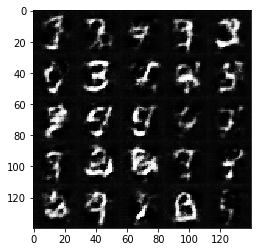

Epoch 1/2 - steps: 310... Discriminator Loss: 1.0244... Generator Loss: 0.9455
Epoch 1/2 - steps: 320... Discriminator Loss: 0.9391... Generator Loss: 1.1515
Epoch 1/2 - steps: 330... Discriminator Loss: 1.0140... Generator Loss: 1.9726
Epoch 1/2 - steps: 340... Discriminator Loss: 1.1308... Generator Loss: 2.1162
Epoch 1/2 - steps: 350... Discriminator Loss: 1.1425... Generator Loss: 0.7612
Epoch 1/2 - steps: 360... Discriminator Loss: 0.9507... Generator Loss: 1.0814
Epoch 1/2 - steps: 370... Discriminator Loss: 0.9279... Generator Loss: 1.4162
Epoch 1/2 - steps: 380... Discriminator Loss: 0.9353... Generator Loss: 1.6230
Epoch 1/2 - steps: 390... Discriminator Loss: 1.5807... Generator Loss: 0.4046
Epoch 1/2 - steps: 400... Discriminator Loss: 1.1258... Generator Loss: 0.7676


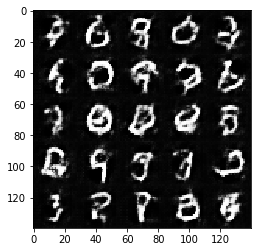

Epoch 1/2 - steps: 410... Discriminator Loss: 0.9306... Generator Loss: 1.5414
Epoch 1/2 - steps: 420... Discriminator Loss: 1.1152... Generator Loss: 1.3005
Epoch 1/2 - steps: 430... Discriminator Loss: 1.0497... Generator Loss: 1.7073
Epoch 1/2 - steps: 440... Discriminator Loss: 1.6706... Generator Loss: 0.3746
Epoch 1/2 - steps: 450... Discriminator Loss: 1.1922... Generator Loss: 1.6861
Epoch 1/2 - steps: 460... Discriminator Loss: 1.4665... Generator Loss: 2.0657
Epoch 1/2 - steps: 470... Discriminator Loss: 1.2754... Generator Loss: 0.5618
Epoch 1/2 - steps: 480... Discriminator Loss: 1.1894... Generator Loss: 0.6848
Epoch 1/2 - steps: 490... Discriminator Loss: 1.0386... Generator Loss: 1.0974
Epoch 1/2 - steps: 500... Discriminator Loss: 1.3998... Generator Loss: 0.4988


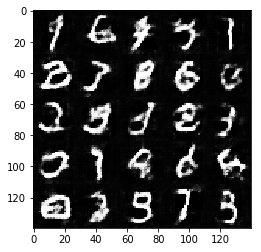

Epoch 1/2 - steps: 510... Discriminator Loss: 1.8778... Generator Loss: 2.9369
Epoch 1/2 - steps: 520... Discriminator Loss: 1.0199... Generator Loss: 1.0408
Epoch 1/2 - steps: 530... Discriminator Loss: 1.1750... Generator Loss: 0.7273
Epoch 1/2 - steps: 540... Discriminator Loss: 0.9661... Generator Loss: 1.1284
Epoch 1/2 - steps: 550... Discriminator Loss: 1.2820... Generator Loss: 2.1454
Epoch 1/2 - steps: 560... Discriminator Loss: 1.4160... Generator Loss: 0.5380
Epoch 1/2 - steps: 570... Discriminator Loss: 1.1084... Generator Loss: 0.9813
Epoch 1/2 - steps: 580... Discriminator Loss: 1.1769... Generator Loss: 0.7606
Epoch 1/2 - steps: 590... Discriminator Loss: 1.2636... Generator Loss: 0.6598
Epoch 1/2 - steps: 600... Discriminator Loss: 1.0537... Generator Loss: 1.5522


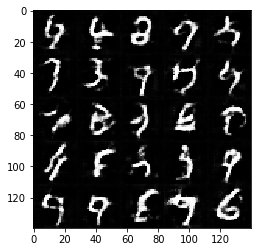

Epoch 1/2 - steps: 610... Discriminator Loss: 0.9791... Generator Loss: 1.1414
Epoch 1/2 - steps: 620... Discriminator Loss: 1.2080... Generator Loss: 1.9747
Epoch 1/2 - steps: 630... Discriminator Loss: 1.0643... Generator Loss: 1.1994
Epoch 1/2 - steps: 640... Discriminator Loss: 1.0849... Generator Loss: 1.0212
Epoch 1/2 - steps: 650... Discriminator Loss: 1.4842... Generator Loss: 0.4374
Epoch 1/2 - steps: 660... Discriminator Loss: 2.7169... Generator Loss: 4.3100
Epoch 1/2 - steps: 670... Discriminator Loss: 1.2183... Generator Loss: 0.6738
Epoch 1/2 - steps: 680... Discriminator Loss: 1.2994... Generator Loss: 0.6997
Epoch 1/2 - steps: 690... Discriminator Loss: 1.2339... Generator Loss: 0.6249
Epoch 1/2 - steps: 700... Discriminator Loss: 0.9898... Generator Loss: 1.0695


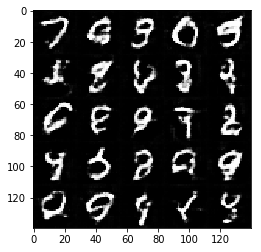

Epoch 1/2 - steps: 710... Discriminator Loss: 1.0667... Generator Loss: 0.8123
Epoch 1/2 - steps: 720... Discriminator Loss: 0.9018... Generator Loss: 1.4982
Epoch 1/2 - steps: 730... Discriminator Loss: 1.6222... Generator Loss: 2.2286
Epoch 1/2 - steps: 740... Discriminator Loss: 1.1545... Generator Loss: 1.0975
Epoch 1/2 - steps: 750... Discriminator Loss: 0.9882... Generator Loss: 1.1130
Epoch 1/2 - steps: 760... Discriminator Loss: 1.2360... Generator Loss: 0.6209
Epoch 1/2 - steps: 770... Discriminator Loss: 1.5745... Generator Loss: 0.3995
Epoch 1/2 - steps: 780... Discriminator Loss: 1.1863... Generator Loss: 0.7160
Epoch 1/2 - steps: 790... Discriminator Loss: 1.1519... Generator Loss: 0.8019
Epoch 1/2 - steps: 800... Discriminator Loss: 1.0846... Generator Loss: 0.8037


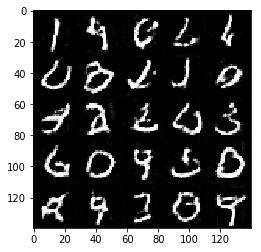

Epoch 1/2 - steps: 810... Discriminator Loss: 0.9328... Generator Loss: 1.3406
Epoch 1/2 - steps: 820... Discriminator Loss: 0.8497... Generator Loss: 1.4065
Epoch 1/2 - steps: 830... Discriminator Loss: 1.2611... Generator Loss: 1.3308
Epoch 1/2 - steps: 840... Discriminator Loss: 1.3278... Generator Loss: 0.7863
Epoch 1/2 - steps: 850... Discriminator Loss: 1.3590... Generator Loss: 0.5797
Epoch 1/2 - steps: 860... Discriminator Loss: 1.4547... Generator Loss: 0.4603
Epoch 1/2 - steps: 870... Discriminator Loss: 1.5998... Generator Loss: 0.3992
Epoch 1/2 - steps: 880... Discriminator Loss: 0.8771... Generator Loss: 1.3228
Epoch 1/2 - steps: 890... Discriminator Loss: 1.4317... Generator Loss: 0.5167
Epoch 1/2 - steps: 900... Discriminator Loss: 1.2166... Generator Loss: 0.6562


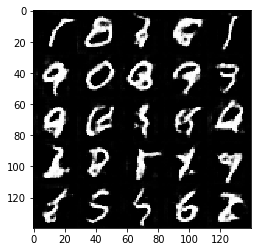

Epoch 1/2 - steps: 910... Discriminator Loss: 1.0692... Generator Loss: 0.8657
Epoch 1/2 - steps: 920... Discriminator Loss: 1.0489... Generator Loss: 0.9944
Epoch 1/2 - steps: 930... Discriminator Loss: 1.2286... Generator Loss: 0.6538
Epoch 2/2 - steps: 940... Discriminator Loss: 0.9317... Generator Loss: 1.1369
Epoch 2/2 - steps: 950... Discriminator Loss: 1.0030... Generator Loss: 0.9488
Epoch 2/2 - steps: 960... Discriminator Loss: 2.5143... Generator Loss: 0.1652
Epoch 2/2 - steps: 970... Discriminator Loss: 1.0514... Generator Loss: 1.1045
Epoch 2/2 - steps: 980... Discriminator Loss: 1.1301... Generator Loss: 1.3966
Epoch 2/2 - steps: 990... Discriminator Loss: 1.1085... Generator Loss: 0.7443
Epoch 2/2 - steps: 1000... Discriminator Loss: 1.0804... Generator Loss: 0.8668


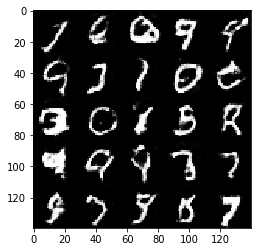

Epoch 2/2 - steps: 1010... Discriminator Loss: 0.9709... Generator Loss: 0.9743
Epoch 2/2 - steps: 1020... Discriminator Loss: 0.9702... Generator Loss: 0.9480
Epoch 2/2 - steps: 1030... Discriminator Loss: 1.0507... Generator Loss: 0.8960
Epoch 2/2 - steps: 1040... Discriminator Loss: 1.0882... Generator Loss: 0.8471
Epoch 2/2 - steps: 1050... Discriminator Loss: 1.1563... Generator Loss: 0.7271
Epoch 2/2 - steps: 1060... Discriminator Loss: 1.4316... Generator Loss: 0.5063
Epoch 2/2 - steps: 1070... Discriminator Loss: 0.9984... Generator Loss: 0.9392
Epoch 2/2 - steps: 1080... Discriminator Loss: 1.0248... Generator Loss: 1.0017
Epoch 2/2 - steps: 1090... Discriminator Loss: 1.0212... Generator Loss: 0.8594
Epoch 2/2 - steps: 1100... Discriminator Loss: 0.9843... Generator Loss: 0.9395


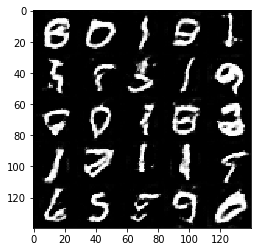

Epoch 2/2 - steps: 1110... Discriminator Loss: 0.9079... Generator Loss: 1.6446
Epoch 2/2 - steps: 1120... Discriminator Loss: 1.0096... Generator Loss: 1.2574
Epoch 2/2 - steps: 1130... Discriminator Loss: 1.1837... Generator Loss: 0.6562
Epoch 2/2 - steps: 1140... Discriminator Loss: 0.9929... Generator Loss: 1.0912
Epoch 2/2 - steps: 1150... Discriminator Loss: 1.1036... Generator Loss: 1.3937
Epoch 2/2 - steps: 1160... Discriminator Loss: 1.5017... Generator Loss: 0.4507
Epoch 2/2 - steps: 1170... Discriminator Loss: 1.1534... Generator Loss: 2.2927
Epoch 2/2 - steps: 1180... Discriminator Loss: 1.4409... Generator Loss: 0.4780
Epoch 2/2 - steps: 1190... Discriminator Loss: 0.9359... Generator Loss: 1.2590
Epoch 2/2 - steps: 1200... Discriminator Loss: 1.3546... Generator Loss: 0.5406


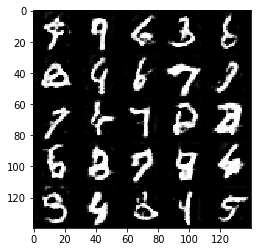

Epoch 2/2 - steps: 1210... Discriminator Loss: 1.4442... Generator Loss: 0.4893
Epoch 2/2 - steps: 1220... Discriminator Loss: 0.8815... Generator Loss: 1.3347
Epoch 2/2 - steps: 1230... Discriminator Loss: 1.0259... Generator Loss: 1.1032
Epoch 2/2 - steps: 1240... Discriminator Loss: 2.3352... Generator Loss: 4.0157
Epoch 2/2 - steps: 1250... Discriminator Loss: 1.0222... Generator Loss: 1.3119
Epoch 2/2 - steps: 1260... Discriminator Loss: 1.1536... Generator Loss: 1.5991
Epoch 2/2 - steps: 1270... Discriminator Loss: 1.5470... Generator Loss: 2.5556
Epoch 2/2 - steps: 1280... Discriminator Loss: 0.9838... Generator Loss: 0.8954
Epoch 2/2 - steps: 1290... Discriminator Loss: 0.9729... Generator Loss: 0.9698
Epoch 2/2 - steps: 1300... Discriminator Loss: 1.0296... Generator Loss: 1.7822


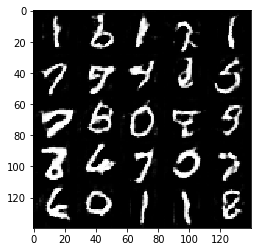

Epoch 2/2 - steps: 1310... Discriminator Loss: 1.1146... Generator Loss: 0.8812
Epoch 2/2 - steps: 1320... Discriminator Loss: 1.1435... Generator Loss: 1.3418
Epoch 2/2 - steps: 1330... Discriminator Loss: 1.0437... Generator Loss: 0.8956
Epoch 2/2 - steps: 1340... Discriminator Loss: 1.9213... Generator Loss: 0.2891
Epoch 2/2 - steps: 1350... Discriminator Loss: 0.9865... Generator Loss: 1.0700
Epoch 2/2 - steps: 1360... Discriminator Loss: 1.3437... Generator Loss: 0.6154
Epoch 2/2 - steps: 1370... Discriminator Loss: 1.2649... Generator Loss: 0.6242
Epoch 2/2 - steps: 1380... Discriminator Loss: 1.0418... Generator Loss: 0.9108
Epoch 2/2 - steps: 1390... Discriminator Loss: 0.8595... Generator Loss: 1.4108
Epoch 2/2 - steps: 1400... Discriminator Loss: 1.0274... Generator Loss: 0.8811


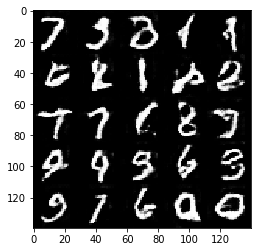

Epoch 2/2 - steps: 1410... Discriminator Loss: 0.8692... Generator Loss: 1.4135
Epoch 2/2 - steps: 1420... Discriminator Loss: 1.9497... Generator Loss: 0.3159
Epoch 2/2 - steps: 1430... Discriminator Loss: 1.1235... Generator Loss: 1.2704
Epoch 2/2 - steps: 1440... Discriminator Loss: 1.0782... Generator Loss: 1.6505
Epoch 2/2 - steps: 1450... Discriminator Loss: 1.0661... Generator Loss: 1.2089
Epoch 2/2 - steps: 1460... Discriminator Loss: 1.1654... Generator Loss: 0.6988
Epoch 2/2 - steps: 1470... Discriminator Loss: 0.8980... Generator Loss: 1.4807
Epoch 2/2 - steps: 1480... Discriminator Loss: 1.5534... Generator Loss: 0.4553
Epoch 2/2 - steps: 1490... Discriminator Loss: 0.9287... Generator Loss: 1.3424
Epoch 2/2 - steps: 1500... Discriminator Loss: 1.1905... Generator Loss: 0.8050


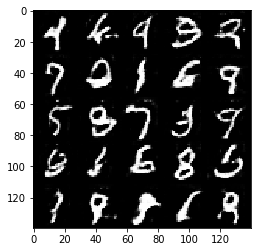

Epoch 2/2 - steps: 1510... Discriminator Loss: 1.3509... Generator Loss: 0.6235
Epoch 2/2 - steps: 1520... Discriminator Loss: 1.1247... Generator Loss: 0.8603
Epoch 2/2 - steps: 1530... Discriminator Loss: 1.0731... Generator Loss: 0.7876
Epoch 2/2 - steps: 1540... Discriminator Loss: 1.1654... Generator Loss: 0.6995
Epoch 2/2 - steps: 1550... Discriminator Loss: 1.0213... Generator Loss: 0.8452
Epoch 2/2 - steps: 1560... Discriminator Loss: 1.1553... Generator Loss: 0.8236
Epoch 2/2 - steps: 1570... Discriminator Loss: 0.9859... Generator Loss: 1.0103
Epoch 2/2 - steps: 1580... Discriminator Loss: 0.9795... Generator Loss: 1.0789
Epoch 2/2 - steps: 1590... Discriminator Loss: 0.9623... Generator Loss: 1.6236
Epoch 2/2 - steps: 1600... Discriminator Loss: 0.9100... Generator Loss: 1.2785


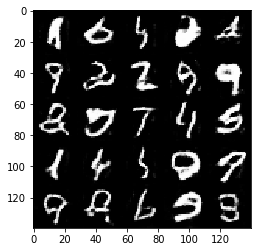

Epoch 2/2 - steps: 1610... Discriminator Loss: 1.8402... Generator Loss: 0.3223
Epoch 2/2 - steps: 1620... Discriminator Loss: 1.2763... Generator Loss: 2.3459
Epoch 2/2 - steps: 1630... Discriminator Loss: 0.8651... Generator Loss: 1.6090
Epoch 2/2 - steps: 1640... Discriminator Loss: 0.9636... Generator Loss: 1.5059
Epoch 2/2 - steps: 1650... Discriminator Loss: 1.1413... Generator Loss: 0.7619
Epoch 2/2 - steps: 1660... Discriminator Loss: 1.0412... Generator Loss: 1.1124
Epoch 2/2 - steps: 1670... Discriminator Loss: 0.8965... Generator Loss: 1.1992
Epoch 2/2 - steps: 1680... Discriminator Loss: 0.7991... Generator Loss: 1.4891
Epoch 2/2 - steps: 1690... Discriminator Loss: 0.8658... Generator Loss: 1.2513
Epoch 2/2 - steps: 1700... Discriminator Loss: 0.9844... Generator Loss: 0.9015


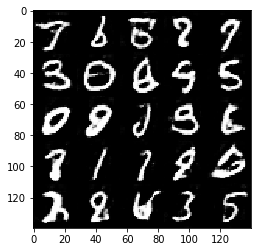

Epoch 2/2 - steps: 1710... Discriminator Loss: 1.0486... Generator Loss: 0.8411
Epoch 2/2 - steps: 1720... Discriminator Loss: 4.1054... Generator Loss: 3.9610
Epoch 2/2 - steps: 1730... Discriminator Loss: 1.0834... Generator Loss: 1.0432
Epoch 2/2 - steps: 1740... Discriminator Loss: 1.0656... Generator Loss: 1.0728
Epoch 2/2 - steps: 1750... Discriminator Loss: 0.8889... Generator Loss: 1.4763
Epoch 2/2 - steps: 1760... Discriminator Loss: 1.0745... Generator Loss: 0.9429
Epoch 2/2 - steps: 1770... Discriminator Loss: 0.9804... Generator Loss: 1.8591
Epoch 2/2 - steps: 1780... Discriminator Loss: 1.0416... Generator Loss: 0.8244
Epoch 2/2 - steps: 1790... Discriminator Loss: 2.5032... Generator Loss: 4.0571
Epoch 2/2 - steps: 1800... Discriminator Loss: 1.2730... Generator Loss: 0.6406


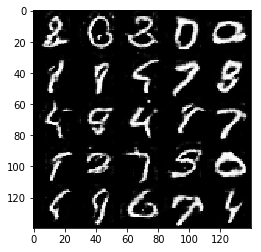

Epoch 2/2 - steps: 1810... Discriminator Loss: 1.2139... Generator Loss: 0.6540
Epoch 2/2 - steps: 1820... Discriminator Loss: 1.2663... Generator Loss: 0.6474
Epoch 2/2 - steps: 1830... Discriminator Loss: 1.1823... Generator Loss: 0.7229
Epoch 2/2 - steps: 1840... Discriminator Loss: 0.9566... Generator Loss: 1.0015
Epoch 2/2 - steps: 1850... Discriminator Loss: 1.0334... Generator Loss: 0.9724
Epoch 2/2 - steps: 1860... Discriminator Loss: 0.9341... Generator Loss: 1.6245
Epoch 2/2 - steps: 1870... Discriminator Loss: 0.8398... Generator Loss: 1.4737


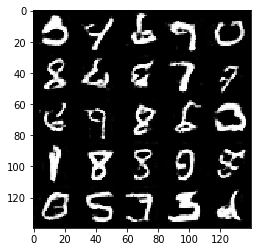

In [25]:
# HAVE TO CHANGE: Try reducing batch_size to (~32 to 64) because
batch_size = 64 #128
z_dim = 128
learning_rate = 0.0003
# Your chosen value for beta1 is goodish. 
# Though 0.5 seems to be the best choice and your results would have had even better looking faces!
beta1 = 0.5 #0.3

# https://www.tensorflow.org/versions/master/api_docs/python/tf/train/AdamOptimizer
# lr_t <- learning_rate * sqrt(1 - beta2^t) / (1 - beta1^t)

tf.reset_default_graph()
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset= helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 - steps: 10... Discriminator Loss: 1.0133... Generator Loss: 1.0313
Epoch 1/1 - steps: 20... Discriminator Loss: 1.0642... Generator Loss: 0.9373
Epoch 1/1 - steps: 30... Discriminator Loss: 0.4719... Generator Loss: 3.9139
Epoch 1/1 - steps: 40... Discriminator Loss: 0.5369... Generator Loss: 2.1443
Epoch 1/1 - steps: 50... Discriminator Loss: 0.5321... Generator Loss: 2.4079
Epoch 1/1 - steps: 60... Discriminator Loss: 2.9199... Generator Loss: 7.1959
Epoch 1/1 - steps: 70... Discriminator Loss: 1.3708... Generator Loss: 0.7825
Epoch 1/1 - steps: 80... Discriminator Loss: 1.5068... Generator Loss: 0.6228
Epoch 1/1 - steps: 90... Discriminator Loss: 1.4505... Generator Loss: 0.5829
Epoch 1/1 - steps: 100... Discriminator Loss: 1.8354... Generator Loss: 0.3958


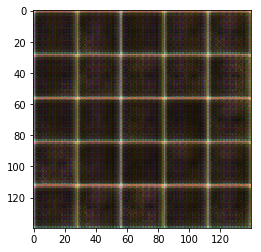

Epoch 1/1 - steps: 110... Discriminator Loss: 1.0264... Generator Loss: 1.0010
Epoch 1/1 - steps: 120... Discriminator Loss: 0.9716... Generator Loss: 1.2845
Epoch 1/1 - steps: 130... Discriminator Loss: 0.8703... Generator Loss: 2.0456
Epoch 1/1 - steps: 140... Discriminator Loss: 1.1202... Generator Loss: 0.9687
Epoch 1/1 - steps: 150... Discriminator Loss: 1.0683... Generator Loss: 0.9439
Epoch 1/1 - steps: 160... Discriminator Loss: 1.2701... Generator Loss: 0.8486
Epoch 1/1 - steps: 170... Discriminator Loss: 1.3625... Generator Loss: 0.6864
Epoch 1/1 - steps: 180... Discriminator Loss: 1.4030... Generator Loss: 0.8222
Epoch 1/1 - steps: 190... Discriminator Loss: 1.7234... Generator Loss: 3.0646
Epoch 1/1 - steps: 200... Discriminator Loss: 1.1709... Generator Loss: 0.6986


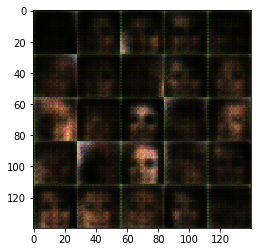

Epoch 1/1 - steps: 210... Discriminator Loss: 1.7113... Generator Loss: 2.9928
Epoch 1/1 - steps: 220... Discriminator Loss: 1.3969... Generator Loss: 0.6541
Epoch 1/1 - steps: 230... Discriminator Loss: 0.8797... Generator Loss: 1.2267
Epoch 1/1 - steps: 240... Discriminator Loss: 1.1538... Generator Loss: 2.4064
Epoch 1/1 - steps: 250... Discriminator Loss: 0.9271... Generator Loss: 1.1783
Epoch 1/1 - steps: 260... Discriminator Loss: 1.6572... Generator Loss: 0.4221
Epoch 1/1 - steps: 270... Discriminator Loss: 1.2670... Generator Loss: 0.7764
Epoch 1/1 - steps: 280... Discriminator Loss: 0.7017... Generator Loss: 1.8939
Epoch 1/1 - steps: 290... Discriminator Loss: 1.1076... Generator Loss: 1.0010
Epoch 1/1 - steps: 300... Discriminator Loss: 1.5591... Generator Loss: 0.5285


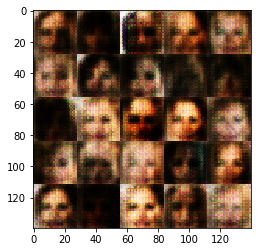

Epoch 1/1 - steps: 310... Discriminator Loss: 2.1164... Generator Loss: 0.2548
Epoch 1/1 - steps: 320... Discriminator Loss: 1.3705... Generator Loss: 0.8298
Epoch 1/1 - steps: 330... Discriminator Loss: 0.8961... Generator Loss: 1.3394
Epoch 1/1 - steps: 340... Discriminator Loss: 0.9328... Generator Loss: 1.1678
Epoch 1/1 - steps: 350... Discriminator Loss: 1.1097... Generator Loss: 0.8491
Epoch 1/1 - steps: 360... Discriminator Loss: 0.9292... Generator Loss: 0.9646
Epoch 1/1 - steps: 370... Discriminator Loss: 1.6146... Generator Loss: 0.4376
Epoch 1/1 - steps: 380... Discriminator Loss: 1.0262... Generator Loss: 0.9313
Epoch 1/1 - steps: 390... Discriminator Loss: 0.9070... Generator Loss: 0.9831
Epoch 1/1 - steps: 400... Discriminator Loss: 1.5866... Generator Loss: 0.4141


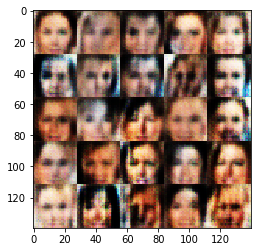

Epoch 1/1 - steps: 410... Discriminator Loss: 1.5883... Generator Loss: 0.4203
Epoch 1/1 - steps: 420... Discriminator Loss: 0.8582... Generator Loss: 1.2395
Epoch 1/1 - steps: 430... Discriminator Loss: 0.8154... Generator Loss: 1.3765
Epoch 1/1 - steps: 440... Discriminator Loss: 1.6569... Generator Loss: 0.4228
Epoch 1/1 - steps: 450... Discriminator Loss: 1.4931... Generator Loss: 5.1950
Epoch 1/1 - steps: 460... Discriminator Loss: 0.9983... Generator Loss: 0.8948
Epoch 1/1 - steps: 470... Discriminator Loss: 1.7477... Generator Loss: 3.2900
Epoch 1/1 - steps: 480... Discriminator Loss: 1.3340... Generator Loss: 0.5901
Epoch 1/1 - steps: 490... Discriminator Loss: 0.7255... Generator Loss: 2.2228
Epoch 1/1 - steps: 500... Discriminator Loss: 0.7667... Generator Loss: 2.9348


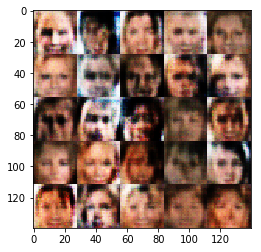

Epoch 1/1 - steps: 510... Discriminator Loss: 1.3962... Generator Loss: 0.5530
Epoch 1/1 - steps: 520... Discriminator Loss: 1.1043... Generator Loss: 0.7856
Epoch 1/1 - steps: 530... Discriminator Loss: 0.5351... Generator Loss: 3.8390
Epoch 1/1 - steps: 540... Discriminator Loss: 0.6750... Generator Loss: 2.9318
Epoch 1/1 - steps: 550... Discriminator Loss: 0.7716... Generator Loss: 3.9372
Epoch 1/1 - steps: 560... Discriminator Loss: 1.1776... Generator Loss: 3.5039
Epoch 1/1 - steps: 570... Discriminator Loss: 0.9631... Generator Loss: 1.0211
Epoch 1/1 - steps: 580... Discriminator Loss: 0.7966... Generator Loss: 1.3414
Epoch 1/1 - steps: 590... Discriminator Loss: 0.9748... Generator Loss: 0.9995
Epoch 1/1 - steps: 600... Discriminator Loss: 1.6289... Generator Loss: 0.3937


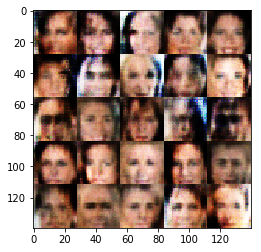

Epoch 1/1 - steps: 610... Discriminator Loss: 0.7784... Generator Loss: 2.7533
Epoch 1/1 - steps: 620... Discriminator Loss: 0.9323... Generator Loss: 0.9823
Epoch 1/1 - steps: 630... Discriminator Loss: 1.1935... Generator Loss: 3.3752
Epoch 1/1 - steps: 640... Discriminator Loss: 0.7837... Generator Loss: 1.6559
Epoch 1/1 - steps: 650... Discriminator Loss: 1.4939... Generator Loss: 0.4857
Epoch 1/1 - steps: 660... Discriminator Loss: 1.0384... Generator Loss: 0.8381
Epoch 1/1 - steps: 670... Discriminator Loss: 0.7568... Generator Loss: 1.4736
Epoch 1/1 - steps: 680... Discriminator Loss: 1.6319... Generator Loss: 2.5229
Epoch 1/1 - steps: 690... Discriminator Loss: 0.8557... Generator Loss: 1.2343
Epoch 1/1 - steps: 700... Discriminator Loss: 1.2519... Generator Loss: 2.5643


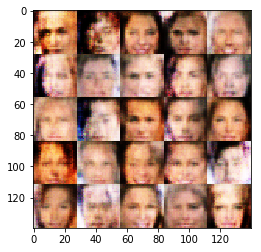

Epoch 1/1 - steps: 710... Discriminator Loss: 1.6692... Generator Loss: 4.1410
Epoch 1/1 - steps: 720... Discriminator Loss: 0.8269... Generator Loss: 1.6399
Epoch 1/1 - steps: 730... Discriminator Loss: 0.7344... Generator Loss: 1.8545
Epoch 1/1 - steps: 740... Discriminator Loss: 1.0699... Generator Loss: 0.7745
Epoch 1/1 - steps: 750... Discriminator Loss: 1.5069... Generator Loss: 2.1602
Epoch 1/1 - steps: 760... Discriminator Loss: 1.3247... Generator Loss: 0.9887
Epoch 1/1 - steps: 770... Discriminator Loss: 1.0507... Generator Loss: 1.4680
Epoch 1/1 - steps: 780... Discriminator Loss: 0.8177... Generator Loss: 1.6029
Epoch 1/1 - steps: 790... Discriminator Loss: 1.0205... Generator Loss: 1.3139
Epoch 1/1 - steps: 800... Discriminator Loss: 1.4130... Generator Loss: 0.5668


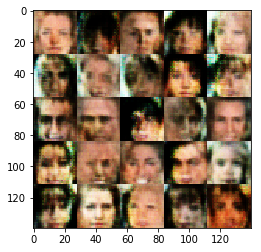

Epoch 1/1 - steps: 810... Discriminator Loss: 1.1071... Generator Loss: 0.8678
Epoch 1/1 - steps: 820... Discriminator Loss: 1.1051... Generator Loss: 1.5479
Epoch 1/1 - steps: 830... Discriminator Loss: 1.0069... Generator Loss: 1.8808
Epoch 1/1 - steps: 840... Discriminator Loss: 1.0643... Generator Loss: 0.8949
Epoch 1/1 - steps: 850... Discriminator Loss: 0.8410... Generator Loss: 3.0856
Epoch 1/1 - steps: 860... Discriminator Loss: 0.8513... Generator Loss: 1.8430
Epoch 1/1 - steps: 870... Discriminator Loss: 1.8861... Generator Loss: 1.5795
Epoch 1/1 - steps: 880... Discriminator Loss: 1.2118... Generator Loss: 1.2165
Epoch 1/1 - steps: 890... Discriminator Loss: 1.3771... Generator Loss: 0.5502
Epoch 1/1 - steps: 900... Discriminator Loss: 1.3253... Generator Loss: 0.6143


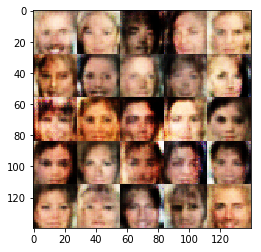

Epoch 1/1 - steps: 910... Discriminator Loss: 1.0547... Generator Loss: 1.2309
Epoch 1/1 - steps: 920... Discriminator Loss: 0.8548... Generator Loss: 1.1411
Epoch 1/1 - steps: 930... Discriminator Loss: 1.1339... Generator Loss: 1.4732
Epoch 1/1 - steps: 940... Discriminator Loss: 0.9641... Generator Loss: 1.7942
Epoch 1/1 - steps: 950... Discriminator Loss: 1.1852... Generator Loss: 0.8061
Epoch 1/1 - steps: 960... Discriminator Loss: 1.0003... Generator Loss: 1.8607
Epoch 1/1 - steps: 970... Discriminator Loss: 1.1120... Generator Loss: 0.8796
Epoch 1/1 - steps: 980... Discriminator Loss: 1.3287... Generator Loss: 1.9590
Epoch 1/1 - steps: 990... Discriminator Loss: 1.3587... Generator Loss: 0.6557
Epoch 1/1 - steps: 1000... Discriminator Loss: 1.1245... Generator Loss: 1.4597


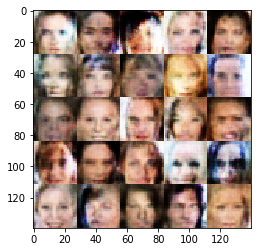

Epoch 1/1 - steps: 1010... Discriminator Loss: 1.7052... Generator Loss: 4.3764
Epoch 1/1 - steps: 1020... Discriminator Loss: 1.0509... Generator Loss: 0.9990
Epoch 1/1 - steps: 1030... Discriminator Loss: 1.1798... Generator Loss: 0.9635
Epoch 1/1 - steps: 1040... Discriminator Loss: 1.0998... Generator Loss: 2.1969
Epoch 1/1 - steps: 1050... Discriminator Loss: 1.0442... Generator Loss: 1.1914
Epoch 1/1 - steps: 1060... Discriminator Loss: 1.0359... Generator Loss: 0.9552
Epoch 1/1 - steps: 1070... Discriminator Loss: 1.1671... Generator Loss: 0.9219
Epoch 1/1 - steps: 1080... Discriminator Loss: 1.4937... Generator Loss: 0.4999
Epoch 1/1 - steps: 1090... Discriminator Loss: 1.3276... Generator Loss: 0.5968
Epoch 1/1 - steps: 1100... Discriminator Loss: 0.7813... Generator Loss: 2.2406


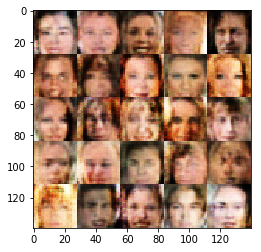

Epoch 1/1 - steps: 1110... Discriminator Loss: 0.9583... Generator Loss: 1.0704
Epoch 1/1 - steps: 1120... Discriminator Loss: 1.2758... Generator Loss: 0.6927
Epoch 1/1 - steps: 1130... Discriminator Loss: 1.3149... Generator Loss: 0.5794
Epoch 1/1 - steps: 1140... Discriminator Loss: 1.2596... Generator Loss: 0.6635
Epoch 1/1 - steps: 1150... Discriminator Loss: 1.4755... Generator Loss: 0.5348
Epoch 1/1 - steps: 1160... Discriminator Loss: 1.3047... Generator Loss: 0.5978
Epoch 1/1 - steps: 1170... Discriminator Loss: 1.1640... Generator Loss: 0.8406
Epoch 1/1 - steps: 1180... Discriminator Loss: 0.8777... Generator Loss: 1.1627
Epoch 1/1 - steps: 1190... Discriminator Loss: 1.4546... Generator Loss: 0.5128
Epoch 1/1 - steps: 1200... Discriminator Loss: 0.7714... Generator Loss: 1.6655


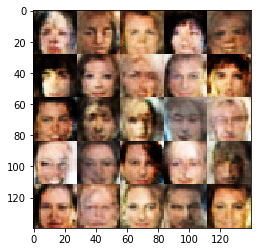

Epoch 1/1 - steps: 1210... Discriminator Loss: 1.3010... Generator Loss: 0.6758
Epoch 1/1 - steps: 1220... Discriminator Loss: 0.8844... Generator Loss: 1.2166
Epoch 1/1 - steps: 1230... Discriminator Loss: 1.4122... Generator Loss: 0.6284
Epoch 1/1 - steps: 1240... Discriminator Loss: 1.0610... Generator Loss: 0.8725
Epoch 1/1 - steps: 1250... Discriminator Loss: 0.9774... Generator Loss: 2.6250
Epoch 1/1 - steps: 1260... Discriminator Loss: 1.7787... Generator Loss: 0.3216
Epoch 1/1 - steps: 1270... Discriminator Loss: 1.9708... Generator Loss: 0.2644
Epoch 1/1 - steps: 1280... Discriminator Loss: 1.0141... Generator Loss: 2.6210
Epoch 1/1 - steps: 1290... Discriminator Loss: 1.7308... Generator Loss: 0.3330
Epoch 1/1 - steps: 1300... Discriminator Loss: 1.1372... Generator Loss: 2.9342


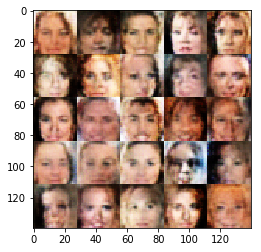

Epoch 1/1 - steps: 1310... Discriminator Loss: 0.9177... Generator Loss: 1.0257
Epoch 1/1 - steps: 1320... Discriminator Loss: 1.5048... Generator Loss: 0.4489
Epoch 1/1 - steps: 1330... Discriminator Loss: 1.4407... Generator Loss: 0.5191
Epoch 1/1 - steps: 1340... Discriminator Loss: 1.4297... Generator Loss: 1.9099
Epoch 1/1 - steps: 1350... Discriminator Loss: 1.3073... Generator Loss: 0.9697
Epoch 1/1 - steps: 1360... Discriminator Loss: 1.1790... Generator Loss: 0.7061
Epoch 1/1 - steps: 1370... Discriminator Loss: 1.0610... Generator Loss: 1.6493
Epoch 1/1 - steps: 1380... Discriminator Loss: 1.0404... Generator Loss: 2.4486
Epoch 1/1 - steps: 1390... Discriminator Loss: 1.0424... Generator Loss: 1.1323
Epoch 1/1 - steps: 1400... Discriminator Loss: 0.9872... Generator Loss: 1.4724


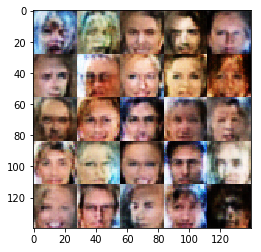

Epoch 1/1 - steps: 1410... Discriminator Loss: 1.0557... Generator Loss: 1.2080
Epoch 1/1 - steps: 1420... Discriminator Loss: 0.9495... Generator Loss: 1.3554
Epoch 1/1 - steps: 1430... Discriminator Loss: 1.3226... Generator Loss: 0.5716
Epoch 1/1 - steps: 1440... Discriminator Loss: 1.0004... Generator Loss: 1.2995
Epoch 1/1 - steps: 1450... Discriminator Loss: 1.0134... Generator Loss: 0.8835
Epoch 1/1 - steps: 1460... Discriminator Loss: 1.2668... Generator Loss: 0.6604
Epoch 1/1 - steps: 1470... Discriminator Loss: 0.7760... Generator Loss: 1.9440
Epoch 1/1 - steps: 1480... Discriminator Loss: 1.2006... Generator Loss: 0.8878
Epoch 1/1 - steps: 1490... Discriminator Loss: 1.2139... Generator Loss: 0.8123
Epoch 1/1 - steps: 1500... Discriminator Loss: 1.4932... Generator Loss: 0.4755


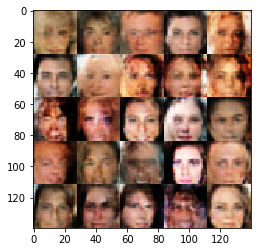

Epoch 1/1 - steps: 1510... Discriminator Loss: 1.0918... Generator Loss: 0.9736
Epoch 1/1 - steps: 1520... Discriminator Loss: 0.6271... Generator Loss: 1.8135
Epoch 1/1 - steps: 1530... Discriminator Loss: 0.7005... Generator Loss: 2.3566
Epoch 1/1 - steps: 1540... Discriminator Loss: 0.9178... Generator Loss: 0.9385
Epoch 1/1 - steps: 1550... Discriminator Loss: 1.6284... Generator Loss: 2.9001
Epoch 1/1 - steps: 1560... Discriminator Loss: 1.0986... Generator Loss: 0.8628
Epoch 1/1 - steps: 1570... Discriminator Loss: 0.9008... Generator Loss: 1.3227
Epoch 1/1 - steps: 1580... Discriminator Loss: 0.9715... Generator Loss: 1.2139
Epoch 1/1 - steps: 1590... Discriminator Loss: 1.3429... Generator Loss: 0.5887
Epoch 1/1 - steps: 1600... Discriminator Loss: 0.9969... Generator Loss: 1.4602


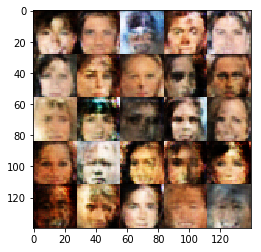

Epoch 1/1 - steps: 1610... Discriminator Loss: 0.8836... Generator Loss: 1.8373
Epoch 1/1 - steps: 1620... Discriminator Loss: 0.7652... Generator Loss: 1.6346
Epoch 1/1 - steps: 1630... Discriminator Loss: 1.1000... Generator Loss: 1.1838
Epoch 1/1 - steps: 1640... Discriminator Loss: 1.9643... Generator Loss: 0.2623
Epoch 1/1 - steps: 1650... Discriminator Loss: 1.3986... Generator Loss: 2.0962
Epoch 1/1 - steps: 1660... Discriminator Loss: 0.8012... Generator Loss: 1.2046
Epoch 1/1 - steps: 1670... Discriminator Loss: 1.0506... Generator Loss: 0.8623
Epoch 1/1 - steps: 1680... Discriminator Loss: 1.2189... Generator Loss: 0.7523
Epoch 1/1 - steps: 1690... Discriminator Loss: 1.1481... Generator Loss: 0.7894
Epoch 1/1 - steps: 1700... Discriminator Loss: 0.9001... Generator Loss: 1.3755


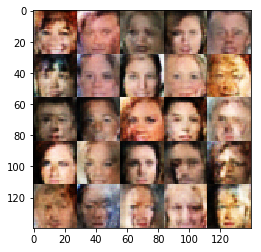

Epoch 1/1 - steps: 1710... Discriminator Loss: 1.1077... Generator Loss: 1.6361
Epoch 1/1 - steps: 1720... Discriminator Loss: 1.2847... Generator Loss: 3.4608
Epoch 1/1 - steps: 1730... Discriminator Loss: 0.9158... Generator Loss: 1.1400
Epoch 1/1 - steps: 1740... Discriminator Loss: 0.9369... Generator Loss: 1.0565
Epoch 1/1 - steps: 1750... Discriminator Loss: 1.4029... Generator Loss: 0.5118
Epoch 1/1 - steps: 1760... Discriminator Loss: 0.9873... Generator Loss: 0.9617
Epoch 1/1 - steps: 1770... Discriminator Loss: 0.8621... Generator Loss: 1.0926
Epoch 1/1 - steps: 1780... Discriminator Loss: 1.1428... Generator Loss: 0.7723
Epoch 1/1 - steps: 1790... Discriminator Loss: 1.7622... Generator Loss: 0.3322
Epoch 1/1 - steps: 1800... Discriminator Loss: 1.4090... Generator Loss: 0.5038


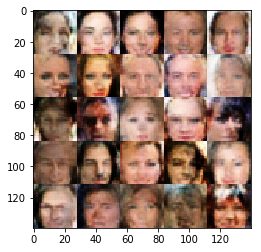

Epoch 1/1 - steps: 1810... Discriminator Loss: 1.1317... Generator Loss: 1.5994
Epoch 1/1 - steps: 1820... Discriminator Loss: 0.9111... Generator Loss: 1.0900
Epoch 1/1 - steps: 1830... Discriminator Loss: 0.9783... Generator Loss: 1.1863
Epoch 1/1 - steps: 1840... Discriminator Loss: 1.1008... Generator Loss: 0.8810
Epoch 1/1 - steps: 1850... Discriminator Loss: 1.0369... Generator Loss: 2.2427
Epoch 1/1 - steps: 1860... Discriminator Loss: 1.1091... Generator Loss: 0.9015
Epoch 1/1 - steps: 1870... Discriminator Loss: 1.6050... Generator Loss: 2.2666
Epoch 1/1 - steps: 1880... Discriminator Loss: 1.5144... Generator Loss: 0.4669
Epoch 1/1 - steps: 1890... Discriminator Loss: 1.2440... Generator Loss: 0.6688
Epoch 1/1 - steps: 1900... Discriminator Loss: 0.9588... Generator Loss: 1.6206


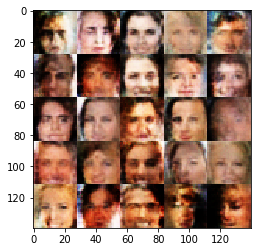

Epoch 1/1 - steps: 1910... Discriminator Loss: 1.1331... Generator Loss: 0.7672
Epoch 1/1 - steps: 1920... Discriminator Loss: 1.8029... Generator Loss: 0.3228
Epoch 1/1 - steps: 1930... Discriminator Loss: 0.9761... Generator Loss: 0.9391
Epoch 1/1 - steps: 1940... Discriminator Loss: 0.6808... Generator Loss: 1.4586
Epoch 1/1 - steps: 1950... Discriminator Loss: 0.3741... Generator Loss: 3.9589
Epoch 1/1 - steps: 1960... Discriminator Loss: 0.4820... Generator Loss: 2.3729
Epoch 1/1 - steps: 1970... Discriminator Loss: 0.5095... Generator Loss: 2.7007
Epoch 1/1 - steps: 1980... Discriminator Loss: 1.1746... Generator Loss: 1.8651
Epoch 1/1 - steps: 1990... Discriminator Loss: 1.0071... Generator Loss: 0.8262
Epoch 1/1 - steps: 2000... Discriminator Loss: 1.0622... Generator Loss: 0.8870


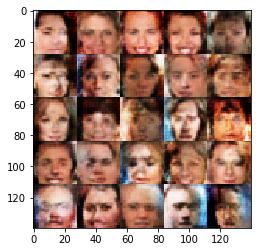

Epoch 1/1 - steps: 2010... Discriminator Loss: 1.1315... Generator Loss: 0.7405
Epoch 1/1 - steps: 2020... Discriminator Loss: 0.6305... Generator Loss: 2.6538
Epoch 1/1 - steps: 2030... Discriminator Loss: 1.1966... Generator Loss: 0.6920
Epoch 1/1 - steps: 2040... Discriminator Loss: 0.7655... Generator Loss: 2.1077
Epoch 1/1 - steps: 2050... Discriminator Loss: 1.1847... Generator Loss: 1.6737
Epoch 1/1 - steps: 2060... Discriminator Loss: 0.9446... Generator Loss: 2.3688
Epoch 1/1 - steps: 2070... Discriminator Loss: 1.1054... Generator Loss: 0.9161
Epoch 1/1 - steps: 2080... Discriminator Loss: 1.2016... Generator Loss: 1.4282
Epoch 1/1 - steps: 2090... Discriminator Loss: 1.1322... Generator Loss: 1.0562
Epoch 1/1 - steps: 2100... Discriminator Loss: 1.0214... Generator Loss: 1.2867


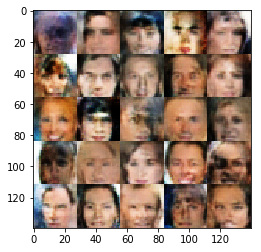

Epoch 1/1 - steps: 2110... Discriminator Loss: 1.3473... Generator Loss: 0.5293
Epoch 1/1 - steps: 2120... Discriminator Loss: 1.1710... Generator Loss: 0.6946
Epoch 1/1 - steps: 2130... Discriminator Loss: 0.6843... Generator Loss: 1.9046
Epoch 1/1 - steps: 2140... Discriminator Loss: 1.0108... Generator Loss: 1.3178
Epoch 1/1 - steps: 2150... Discriminator Loss: 1.1636... Generator Loss: 0.7956
Epoch 1/1 - steps: 2160... Discriminator Loss: 1.1153... Generator Loss: 0.7614
Epoch 1/1 - steps: 2170... Discriminator Loss: 0.6896... Generator Loss: 1.8802
Epoch 1/1 - steps: 2180... Discriminator Loss: 1.7737... Generator Loss: 0.3155
Epoch 1/1 - steps: 2190... Discriminator Loss: 1.2156... Generator Loss: 1.4081
Epoch 1/1 - steps: 2200... Discriminator Loss: 1.3815... Generator Loss: 1.8635


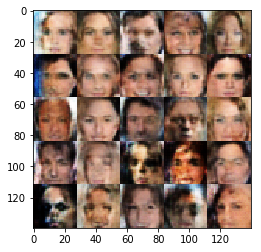

Epoch 1/1 - steps: 2210... Discriminator Loss: 1.2637... Generator Loss: 1.0804
Epoch 1/1 - steps: 2220... Discriminator Loss: 1.0577... Generator Loss: 1.1519
Epoch 1/1 - steps: 2230... Discriminator Loss: 1.1237... Generator Loss: 0.8368
Epoch 1/1 - steps: 2240... Discriminator Loss: 0.9950... Generator Loss: 1.7450
Epoch 1/1 - steps: 2250... Discriminator Loss: 0.9675... Generator Loss: 1.5578
Epoch 1/1 - steps: 2260... Discriminator Loss: 1.1287... Generator Loss: 0.9300
Epoch 1/1 - steps: 2270... Discriminator Loss: 1.5236... Generator Loss: 0.4463
Epoch 1/1 - steps: 2280... Discriminator Loss: 1.0941... Generator Loss: 1.2204
Epoch 1/1 - steps: 2290... Discriminator Loss: 1.2718... Generator Loss: 1.6170
Epoch 1/1 - steps: 2300... Discriminator Loss: 1.0939... Generator Loss: 0.7699


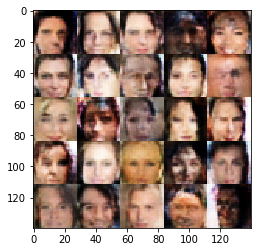

Epoch 1/1 - steps: 2310... Discriminator Loss: 0.7281... Generator Loss: 2.3881
Epoch 1/1 - steps: 2320... Discriminator Loss: 1.6511... Generator Loss: 2.2919
Epoch 1/1 - steps: 2330... Discriminator Loss: 1.3725... Generator Loss: 0.6002
Epoch 1/1 - steps: 2340... Discriminator Loss: 1.1997... Generator Loss: 0.7312
Epoch 1/1 - steps: 2350... Discriminator Loss: 1.2191... Generator Loss: 0.7231
Epoch 1/1 - steps: 2360... Discriminator Loss: 1.3088... Generator Loss: 0.6541
Epoch 1/1 - steps: 2370... Discriminator Loss: 1.3352... Generator Loss: 0.5294
Epoch 1/1 - steps: 2380... Discriminator Loss: 1.0454... Generator Loss: 0.8502
Epoch 1/1 - steps: 2390... Discriminator Loss: 1.1311... Generator Loss: 1.1276
Epoch 1/1 - steps: 2400... Discriminator Loss: 0.9519... Generator Loss: 1.0059


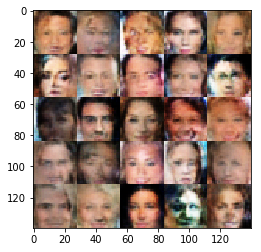

Epoch 1/1 - steps: 2410... Discriminator Loss: 1.2704... Generator Loss: 0.5935
Epoch 1/1 - steps: 2420... Discriminator Loss: 0.8032... Generator Loss: 1.6906
Epoch 1/1 - steps: 2430... Discriminator Loss: 0.9947... Generator Loss: 0.9497
Epoch 1/1 - steps: 2440... Discriminator Loss: 1.1788... Generator Loss: 0.8778
Epoch 1/1 - steps: 2450... Discriminator Loss: 0.9204... Generator Loss: 1.1693
Epoch 1/1 - steps: 2460... Discriminator Loss: 1.4178... Generator Loss: 0.5088
Epoch 1/1 - steps: 2470... Discriminator Loss: 1.1989... Generator Loss: 1.2035
Epoch 1/1 - steps: 2480... Discriminator Loss: 1.7693... Generator Loss: 0.3438
Epoch 1/1 - steps: 2490... Discriminator Loss: 1.1620... Generator Loss: 0.7446
Epoch 1/1 - steps: 2500... Discriminator Loss: 1.0613... Generator Loss: 0.8329


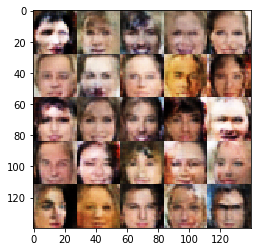

Epoch 1/1 - steps: 2510... Discriminator Loss: 1.5129... Generator Loss: 0.4524
Epoch 1/1 - steps: 2520... Discriminator Loss: 2.8683... Generator Loss: 0.1228
Epoch 1/1 - steps: 2530... Discriminator Loss: 1.3214... Generator Loss: 0.6927
Epoch 1/1 - steps: 2540... Discriminator Loss: 1.0730... Generator Loss: 1.0738
Epoch 1/1 - steps: 2550... Discriminator Loss: 0.8460... Generator Loss: 1.8604
Epoch 1/1 - steps: 2560... Discriminator Loss: 1.4665... Generator Loss: 0.5086
Epoch 1/1 - steps: 2570... Discriminator Loss: 1.2750... Generator Loss: 0.6394
Epoch 1/1 - steps: 2580... Discriminator Loss: 1.1005... Generator Loss: 1.6579
Epoch 1/1 - steps: 2590... Discriminator Loss: 1.3793... Generator Loss: 0.5324
Epoch 1/1 - steps: 2600... Discriminator Loss: 1.2199... Generator Loss: 0.7797


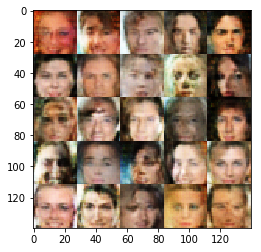

Epoch 1/1 - steps: 2610... Discriminator Loss: 1.0669... Generator Loss: 0.8549
Epoch 1/1 - steps: 2620... Discriminator Loss: 1.4956... Generator Loss: 0.4672
Epoch 1/1 - steps: 2630... Discriminator Loss: 1.3981... Generator Loss: 0.5234
Epoch 1/1 - steps: 2640... Discriminator Loss: 1.1232... Generator Loss: 0.8174
Epoch 1/1 - steps: 2650... Discriminator Loss: 1.0414... Generator Loss: 1.0872
Epoch 1/1 - steps: 2660... Discriminator Loss: 1.0496... Generator Loss: 1.8536
Epoch 1/1 - steps: 2670... Discriminator Loss: 1.2857... Generator Loss: 1.7715
Epoch 1/1 - steps: 2680... Discriminator Loss: 1.2810... Generator Loss: 0.6700
Epoch 1/1 - steps: 2690... Discriminator Loss: 0.9942... Generator Loss: 1.0090
Epoch 1/1 - steps: 2700... Discriminator Loss: 1.5811... Generator Loss: 0.4286


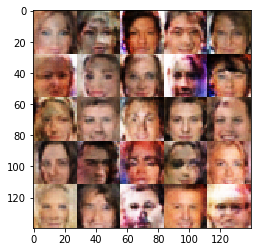

Epoch 1/1 - steps: 2710... Discriminator Loss: 1.3119... Generator Loss: 0.5583
Epoch 1/1 - steps: 2720... Discriminator Loss: 0.6909... Generator Loss: 1.8214
Epoch 1/1 - steps: 2730... Discriminator Loss: 1.1124... Generator Loss: 1.3726
Epoch 1/1 - steps: 2740... Discriminator Loss: 1.3083... Generator Loss: 2.7672
Epoch 1/1 - steps: 2750... Discriminator Loss: 1.7097... Generator Loss: 0.3676
Epoch 1/1 - steps: 2760... Discriminator Loss: 1.5400... Generator Loss: 0.4559
Epoch 1/1 - steps: 2770... Discriminator Loss: 1.4007... Generator Loss: 1.3568
Epoch 1/1 - steps: 2780... Discriminator Loss: 1.3578... Generator Loss: 0.6258
Epoch 1/1 - steps: 2790... Discriminator Loss: 0.9297... Generator Loss: 1.1443
Epoch 1/1 - steps: 2800... Discriminator Loss: 1.3203... Generator Loss: 0.5650


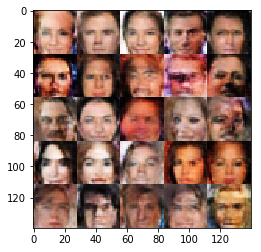

Epoch 1/1 - steps: 2810... Discriminator Loss: 1.3113... Generator Loss: 0.6596
Epoch 1/1 - steps: 2820... Discriminator Loss: 1.2330... Generator Loss: 0.7086
Epoch 1/1 - steps: 2830... Discriminator Loss: 1.7709... Generator Loss: 1.9407
Epoch 1/1 - steps: 2840... Discriminator Loss: 0.9670... Generator Loss: 1.2701
Epoch 1/1 - steps: 2850... Discriminator Loss: 1.0690... Generator Loss: 0.8207
Epoch 1/1 - steps: 2860... Discriminator Loss: 1.1278... Generator Loss: 0.9493
Epoch 1/1 - steps: 2870... Discriminator Loss: 1.2035... Generator Loss: 0.9662
Epoch 1/1 - steps: 2880... Discriminator Loss: 0.9525... Generator Loss: 0.9942
Epoch 1/1 - steps: 2890... Discriminator Loss: 1.3803... Generator Loss: 0.5494
Epoch 1/1 - steps: 2900... Discriminator Loss: 1.3768... Generator Loss: 0.5090


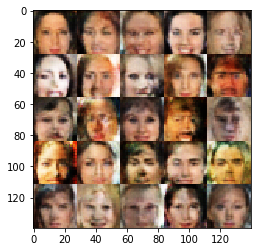

Epoch 1/1 - steps: 2910... Discriminator Loss: 1.5461... Generator Loss: 0.4590
Epoch 1/1 - steps: 2920... Discriminator Loss: 1.1232... Generator Loss: 1.0041
Epoch 1/1 - steps: 2930... Discriminator Loss: 1.2274... Generator Loss: 0.7485
Epoch 1/1 - steps: 2940... Discriminator Loss: 0.9830... Generator Loss: 1.1200
Epoch 1/1 - steps: 2950... Discriminator Loss: 1.2026... Generator Loss: 0.8124
Epoch 1/1 - steps: 2960... Discriminator Loss: 1.1649... Generator Loss: 0.7723
Epoch 1/1 - steps: 2970... Discriminator Loss: 1.0795... Generator Loss: 1.4088
Epoch 1/1 - steps: 2980... Discriminator Loss: 1.5455... Generator Loss: 0.4437
Epoch 1/1 - steps: 2990... Discriminator Loss: 1.2381... Generator Loss: 0.7631
Epoch 1/1 - steps: 3000... Discriminator Loss: 1.3601... Generator Loss: 0.5859


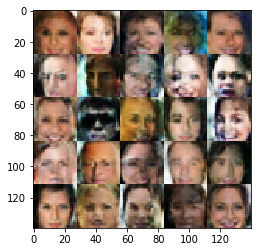

Epoch 1/1 - steps: 3010... Discriminator Loss: 1.1872... Generator Loss: 0.7586
Epoch 1/1 - steps: 3020... Discriminator Loss: 1.0261... Generator Loss: 1.2080
Epoch 1/1 - steps: 3030... Discriminator Loss: 1.5308... Generator Loss: 0.4589
Epoch 1/1 - steps: 3040... Discriminator Loss: 1.1681... Generator Loss: 0.7192
Epoch 1/1 - steps: 3050... Discriminator Loss: 1.2866... Generator Loss: 1.5772
Epoch 1/1 - steps: 3060... Discriminator Loss: 1.3861... Generator Loss: 0.5030
Epoch 1/1 - steps: 3070... Discriminator Loss: 1.0832... Generator Loss: 1.1592
Epoch 1/1 - steps: 3080... Discriminator Loss: 1.3254... Generator Loss: 1.7166
Epoch 1/1 - steps: 3090... Discriminator Loss: 1.3383... Generator Loss: 0.6157
Epoch 1/1 - steps: 3100... Discriminator Loss: 1.1704... Generator Loss: 0.8734


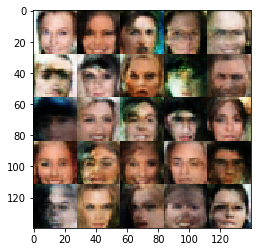

Epoch 1/1 - steps: 3110... Discriminator Loss: 1.0759... Generator Loss: 1.4898
Epoch 1/1 - steps: 3120... Discriminator Loss: 0.9901... Generator Loss: 1.2421
Epoch 1/1 - steps: 3130... Discriminator Loss: 1.4484... Generator Loss: 0.5821
Epoch 1/1 - steps: 3140... Discriminator Loss: 1.0118... Generator Loss: 1.3733
Epoch 1/1 - steps: 3150... Discriminator Loss: 1.0886... Generator Loss: 0.9700
Epoch 1/1 - steps: 3160... Discriminator Loss: 0.9862... Generator Loss: 0.9717


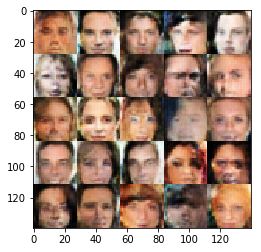

In [26]:
# HAVE TO CHANGE: Try reducing batch_size to (~32 to 64) because
batch_size = 64 #128
z_dim = 128
learning_rate = 0.0003
# Your chosen value for beta1 is goodish. 
# Though 0.5 seems to be the best choice and your results would have had even better looking faces!
beta1 = 0.5 #0.3
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.